# Лабораторна робота 2В. Багатошаровий персептрон
Виконав студент групи ФІ-21, Голуб Михайло

In [1]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install scikit-learn
%pip install kagglehub[pandas-datasets]
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Набір даних ECG Heartbeat Categorization Dataset

### Опис датасету
This dataset is composed of two collections of heartbeat signals derived from two famous datasets in heartbeat classification, the MIT-BIH Arrhythmia Dataset and The PTB Diagnostic ECG Database. The number of samples in both collections is large enough for training a deep neural network.

This dataset has been used in exploring heartbeat classification using deep neural network architectures, and observing some of the capabilities of transfer learning on it. The signals correspond to electrocardiogram (ECG) shapes of heartbeats for the normal case and the cases affected by different arrhythmias and myocardial infarction. These signals are preprocessed and segmented, with each segment corresponding to a heartbeat.

#### Content

##### Arrhythmia Dataset
* Number of Samples: 109446
* Number of Categories: 5
* Sampling Frequency: 125Hz
* Data Source: Physionet's MIT-BIH Arrhythmia Dataset
* Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

##### The PTB Diagnostic ECG Database
* Number of Samples: 14552
* Number of Categories: 2
* Sampling Frequency: 125Hz
* Data Source: Physionet's PTB Diagnostic Database

Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.

#### Data Files
This dataset consists of a series of CSV files. Each of these CSV files contain a matrix, with each row representing an example in that portion of the dataset. The final element of each row denotes the class to which that example belongs.

### Використання даних
В даній роботі будуть використані дані з датасету аритмії з класами:

0. "N" Normal heartbeat (including normal beats, left/right bundle branch block, atrial escape, nodal escape) 
1. "S" Supra-ventricular premature beat (including atrial premature, aberrant atrial premature, nodal premature, supra-ventricular premature) 
1. "V" Ventricular beat (including premature ventricular contraction, ventricular escape) 
1. "F" Fusion beat of ventricular + normal 
1. "Q" Unclassifiable beat (including paced beats, fusion of paced & normal, and other unclassifiable)

Ці дані вже поділені на тестовий та навчальний датасети

### Завантаження даних

In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Download latest version
path = kagglehub.dataset_download("shayanfazeli/heartbeat")

print("Path to dataset files:", path)

c:\Users\misha\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\misha\.cache\kagglehub\datasets\shayanfazeli\heartbeat\versions\1


In [3]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import copy

matplotlib.rcParams['figure.figsize'] = (10, 10)

df_test = pd.read_csv(path+"\mitbih_test.csv", header = None)
df_train = pd.read_csv(path+"\mitbih_train.csv", header = None)
df_train.head(5)
print(len(df_train))

<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
C:\Users\misha\AppData\Local\Temp\ipykernel_30688\1428009908.py:9: SyntaxWarning: invalid escape sequence '\m'
  df_test = pd.read_csv(path+"\mitbih_test.csv", header = None)
C:\Users\misha\AppData\Local\Temp\ipykernel_30688\1428009908.py:10: SyntaxWarning: invalid escape sequence '\m'
  df_train = pd.read_csv(path+"\mitbih_train.csv", header = None)


87554


Дані доповнені нулями щоб містити 188 значень в рядку, де 187 колонка це клас від 0 до 4. З набору даних можна виключити праві колонки з високою кількістю пустих значень, оскільки вони не несуть значної кількості корисної інформації, але потребуватимуть ускладнення персептрона.

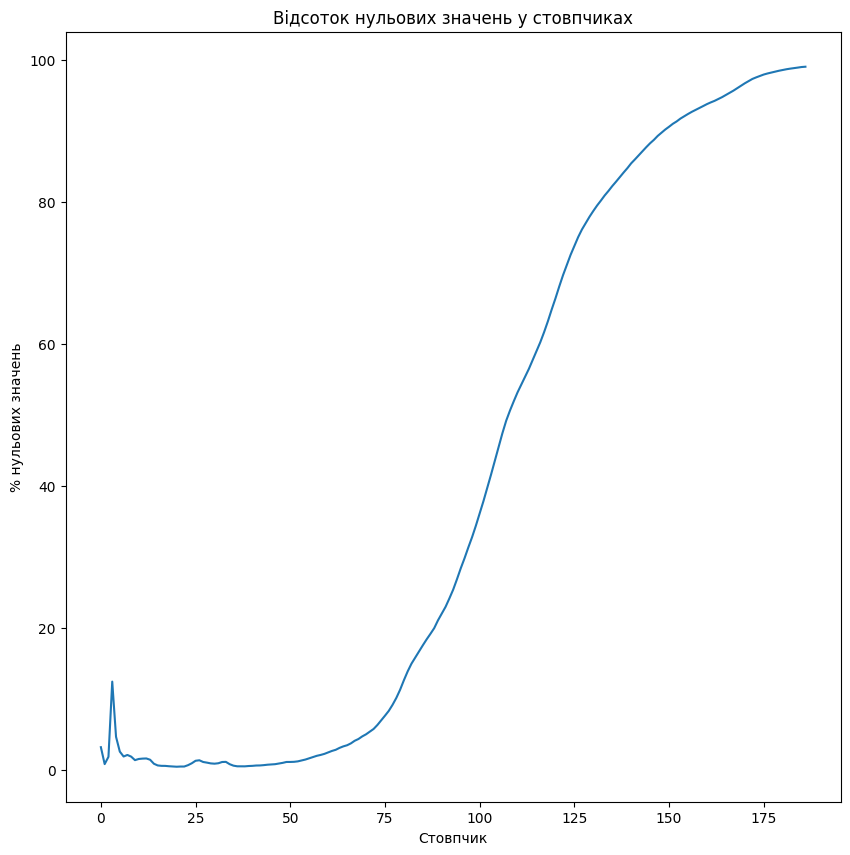

In [4]:
zeros_in_columns = (len(df_train) - np.count_nonzero(df_train.drop(187, axis=1), axis = 0))*100/len(df_train)
plt.plot(range(zeros_in_columns.shape[0]), zeros_in_columns)
plt.title("Відсоток нульових значень у стовпчиках")
plt.xlabel("Стовпчик")
plt.ylabel("% нульових значень")
pass

В якості корисних даних обрано перші 128 значень

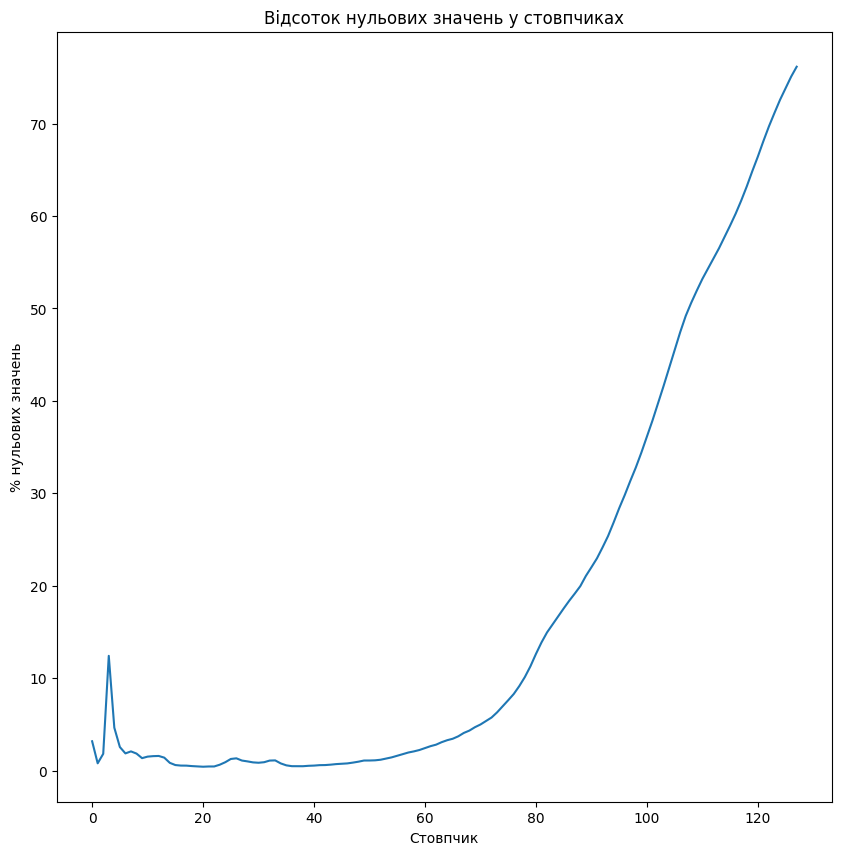

In [5]:
zeros_in_columns = (len(df_train) - np.count_nonzero(df_train.drop(list(range(128,188)), axis=1), axis = 0))*100/len(df_train)
plt.plot(range(zeros_in_columns.shape[0]), zeros_in_columns)
plt.title("Відсоток нульових значень у стовпчиках")
plt.xlabel("Стовпчик")
plt.ylabel("% нульових значень")
pass

In [6]:
df_test = df_test.drop(list(range(128,187)), axis=1)
df_train = df_train.drop(list(range(128,187)), axis=1)

Також не несуть корисної інформації рядки що повністю або майже частково складаються з нулів

Межа 99% даних: 77


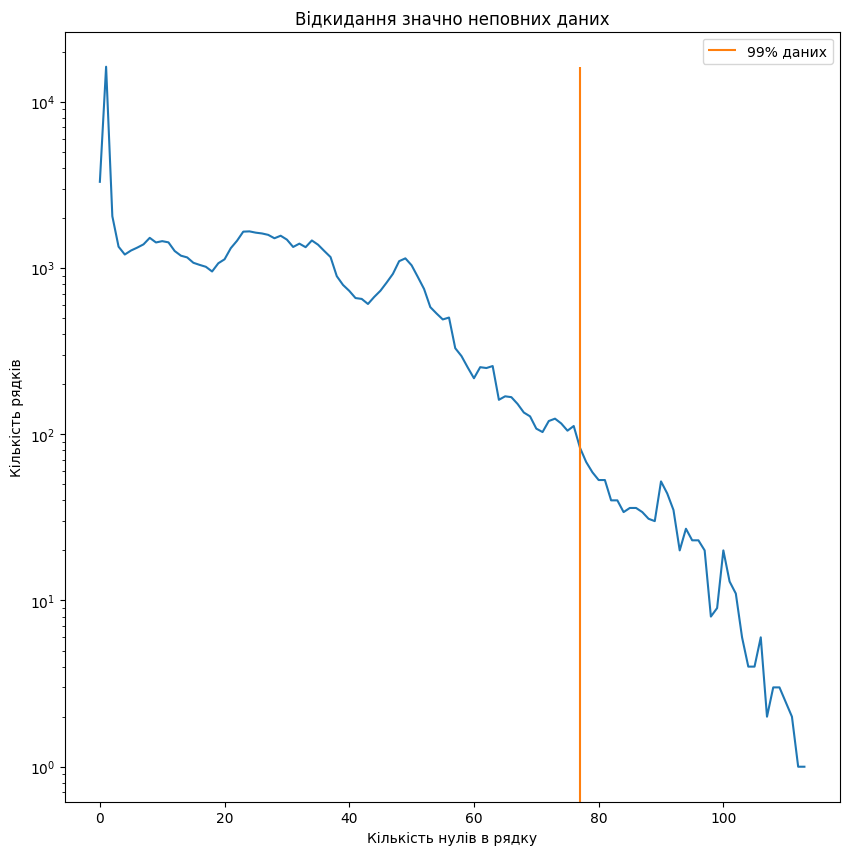

In [7]:
zeros_in_rows = (len(df_train.columns) - 1 - np.count_nonzero(df_train.drop(187, axis=1), axis = 1))
rows_count = np.unique(zeros_in_rows, return_counts=True)
plt.plot(rows_count[0], rows_count[1])


counter = 0
zeros_sum = np.sum(rows_count[1])
divider = 0.99
line = 0
for i in range(len(rows_count[0])):
    counter += rows_count[1][i]
    if counter > zeros_sum * divider:
        line = rows_count[0][i]
        break
print("Межа 99% даних:", line)
plt.vlines(line, 0 ,max(rows_count[1]), colors = "C1", label = "99% даних")
plt.yscale("log")
plt.title("Відкидання значно неповних даних")
plt.xlabel("Кількість нулів в рядку")
plt.ylabel("Кількість рядків")
plt.legend()
pass

Таким чином можна з незначними наслідками відкинути рядки в яких більше 80 нулів

In [8]:
drop_rows_indicies = np.where(zeros_in_rows > 80)[0]
df_train = df_train.drop(drop_rows_indicies, axis = 0)

Приклади рядків з отриманого набору даних:

(<Axes: >, [<matplotlib.lines.Line2D at 0x27b818e8dd0>])

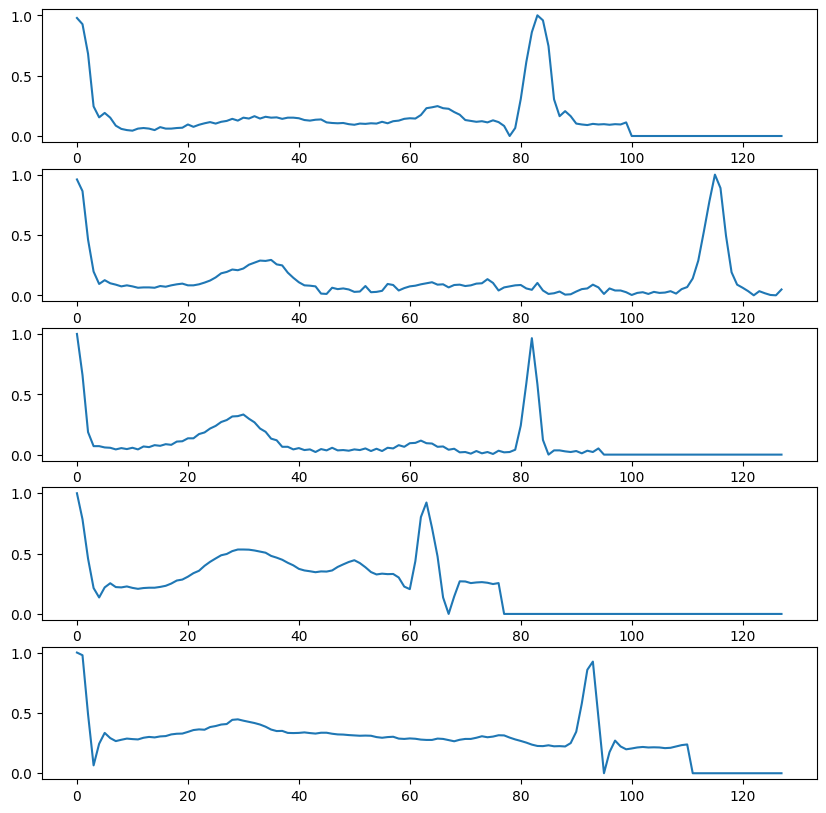

In [9]:
plt.subplot(511), plt.plot(df_train.drop(187,axis = 1).loc[0])
plt.subplot(512), plt.plot(df_train.drop(187,axis = 1).loc[1])
plt.subplot(513), plt.plot(df_train.drop(187,axis = 1).loc[2])
plt.subplot(514), plt.plot(df_train.drop(187,axis = 1).loc[100])
plt.subplot(515), plt.plot(df_train.drop(187,axis = 1).loc[20000])

### Балансування навчального набору даних
Оскільки набір містить багато класу N, його необхідно балансувати:

In [10]:
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder

def balance_classes(df, label_col, max_count = None):
    classes = df[label_col].unique()
    if max_count is None:
        max_count = df[label_col].value_counts().max()
    
    balanced_parts = []
    for c in classes:
        subset = df[df[label_col] == c]
        upsampled = resample(subset, 
                             replace=True,
                             n_samples=max_count,
                             random_state=42)
        balanced_parts.append(upsampled)
    return pd.concat(balanced_parts).sample(frac=1, random_state=42).reset_index(drop=True)

df_balanced = balance_classes(df_train, 187)
X = df_balanced.drop(187, axis=1).to_numpy()
X = (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 1e-9)
X_test = df_test.drop(187, axis = 1).to_numpy()
X_test = (X_test - np.mean(X_test, axis=0)) / (np.std(X_test, axis=0) + 1e-9)
y = df_balanced[187].to_numpy().reshape(-1, 1)
enc = OneHotEncoder(sparse_output=False)
Y = enc.fit_transform(y)

y_test = df_test[187].to_numpy().reshape(-1, 1)
enc = OneHotEncoder(sparse_output=False)
Y_test = enc.fit_transform(y)


# Побудова багатошарового персептрона

На вхід подається 64 значення від 0 до 1 у вигляді вектора. На вихід персептрон має видати один з 5 класів.
Можна використати шари:
1. Вхідний шар з 128 значеннями
1. Dense шар з 64 нейронами
1. Dense шар з 32 нейронами
1. Dense шар з 16 нейронами
1. Dense шар з 8 нейронами
1. Вихідний шар з 5 нейронами і активацією SoftMax

### Функції необхідні для MLP

In [ ]:
def softmax(x):
    exp_x = 
    return exp_x / np.sum(exp_x)

def relu(x):
    return np.maximum(0, x)

def relu_deriv(x):
    return (x > 0).astype(float)

def categorical_crossentropy(y_true, y_pred):
    eps = 1e-9
    return -np.sum(y_true * np.log(y_pred + eps))

def categorical_crossentropy_deriv(y_true, y_pred):
    eps = 1e-9
    return -(y_true / (y_pred + eps))

def precision_score(y_true, y_pred):
    y_true_cls = np.argmax(y_true, axis=1)
    y_pred_cls = np.argmax(y_pred, axis=1)

    precisions = []
    for c in np.unique(y_true_cls):
        tp = np.sum((y_pred_cls == c) & (y_true_cls == c))
        fp = np.sum((y_pred_cls == c) & (y_true_cls != c))
        prec = tp / (tp + fp + 1e-9)
        precisions.append(prec)
    return np.mean(precisions)

def f1_score_macro(y_true, y_pred):
    y_true_cls = np.argmax(y_true, axis=1)
    y_pred_cls = np.argmax(y_pred, axis=1)
    classes = np.unique(y_true_cls)

    f1s = []
    for c in classes:
        tp = np.sum((y_pred_cls == c) & (y_true_cls == c))
        fp = np.sum((y_pred_cls == c) & (y_true_cls != c))
        fn = np.sum((y_pred_cls != c) & (y_true_cls == c))
        precision = tp / (tp + fp + 1e-9)
        recall = tp / (tp + fn + 1e-9)
        f1 = 2 * precision * recall / (precision + recall + 1e-9)
        f1s.append(f1)
    return np.mean(f1s)

def stable_softmax(x):
    x = x - np.max(x, axis=1, keepdims=True)
    e = np.exp(x)
    return e / np.sum(e, axis=1, keepdims=True)

### Шари персептрону

In [12]:
class DenseLayer:
    def __init__(self, input_size, output_size, activation_function, activation_deriv):
        self.activation_function = activation_function
        self.activation_deriv = activation_deriv

        limit = np.sqrt(2 / input_size)
        self.W = np.random.randn(input_size, output_size) * limit
        self.b = np.zeros((1, output_size))

    def forward(self, X):
        X = np.clip(X, -10, 10)
        self.last_input = X

        z = X @ self.W + self.b
        z = np.nan_to_num(z, nan=0.0, posinf=1e6, neginf=-1e6)
        z = np.clip(z, -50, 50)

        self.last_z = z
        self.last_output = self.activation_function(z)
        return self.last_output

    def backward(self, grad_output, lr, l2_lambda=0.001):
        grad_z = grad_output * self.activation_deriv(self.last_z)
        dW = self.last_input.T @ grad_z + 2 * l2_lambda * self.W
        db = np.sum(grad_z, axis=0, keepdims=True)
        grad_input = grad_z @ self.W.T

        self.W -= lr * np.clip(dW, -1, 1)
        self.b -= lr * np.clip(db, -1, 1)

        self.W = np.nan_to_num(self.W, nan=0.0, posinf=1e3, neginf=-1e3)
        grad_input = np.nan_to_num(grad_input, nan=0.0, posinf=1e3, neginf=-1e3)

        return grad_input

class Conv1DLayer:
    def __init__(self, input_channels, output_channels, kernel_size, activation, activation_deriv):
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.kernel_size = kernel_size
        self.activation = activation
        self.activation_deriv = activation_deriv
        limit = np.sqrt(6 / (input_channels * kernel_size + output_channels))
        self.W = np.random.uniform(-limit, limit, (output_channels, input_channels, kernel_size))
        self.b = np.zeros((output_channels,))

    def forward(self, X):
        if X.ndim == 2:
            X = X[..., np.newaxis]
        self.last_input = X
        batch, length, in_ch = X.shape
        new_len = length - self.kernel_size + 1

        Z = np.zeros((batch, new_len, self.output_channels))
        for o in range(self.output_channels):
            for i in range(self.kernel_size):
                Z[:, :, o] += X[:, i:i+new_len, :] @ self.W[o, :, i]
            Z[:, :, o] += self.b[o]

        self.last_z = Z
        self.last_output = self.activation(Z)
        return self.last_output

    def backward(self, grad_output, lr, l2_lambda=0.0):
        X = self.last_input
        batch, length, in_ch = X.shape
        new_len = length - self.kernel_size + 1
        dZ = grad_output * self.activation_deriv(self.last_z)

        dW = np.zeros_like(self.W)
        db = np.sum(dZ, axis=(0, 1))
        dX = np.zeros_like(X)

        for o in range(self.output_channels):
            for i in range(self.kernel_size):
                dW[o, :, i] = np.sum(
                    X[:, i:i+new_len, :] * dZ[:, :, o][:, :, np.newaxis],
                    axis=(0, 1)
                )
                for j in range(new_len):
                    dX[:, i+j, :] += dZ[:, j, o][:, np.newaxis] * self.W[o, :, i]

        self.W -= lr * (dW / batch + 2 * l2_lambda * self.W)
        self.b -= lr * db / batch

        return dX

    
class MaxPool1DLayer:
    def __init__(self, pool_size):
        self.pool_size = pool_size

    def forward(self, X):
        batch, length, channels = X.shape
        new_len = length // self.pool_size
        X_reshaped = X[:, :new_len*self.pool_size, :].reshape(batch, new_len, self.pool_size, channels)
        self.last_input = X
        self.last_shape = X.shape
        self.new_len = new_len
        self.last_mask = (X_reshaped == X_reshaped.max(axis=2, keepdims=True))
        return X_reshaped.max(axis=2)

    def backward(self, grad_output, lr, l2_lambda=0.0):
        batch, length, channels = self.last_shape
        grad_input = np.zeros_like(self.last_input)

        grad_output_expanded = grad_output[:, :, np.newaxis, :]  # (B, new_len, 1, C)
        grad_input_reshaped = grad_input[:, :self.new_len*self.pool_size, :].reshape(batch, self.new_len, self.pool_size, channels)

        grad_input_reshaped += grad_output_expanded * self.last_mask

        return grad_input


class DropoutLayer:
    def __init__(self, p=0.5):
        self.p = p

    def forward(self, X, train=True):
        if train:
            self.mask = (np.random.rand(*X.shape) > self.p).astype(float)
            return X * self.mask / (1 - self.p)
        else:
            return X

    def backward(self, grad_output, lr, l2_lambda=0.0):
        return grad_output * self.mask / (1 - self.p)

class FlattenLayer:
    def forward(self, X):
        self.input_shape = X.shape
        return X.reshape(X.shape[0], -1)

    def backward(self, grad, lr=None, l2_lambda=None):
        return grad.reshape(self.input_shape)

### Багатошаровий персептрон

In [13]:
class MLP:
    def __init__(self, layers, lr=0.01, loss=categorical_crossentropy, loss_deriv=categorical_crossentropy_deriv):
        self.lr = lr
        self.layers = layers
        self.loss = loss
        self.loss_deriv = loss_deriv

    def forward(self, X, best_layers=False):
        out = X
        layers = self.best_layers if best_layers else self.layers

        for i, layer in enumerate(layers):
            if isinstance(layer, Conv1DLayer) and out.ndim == 2:
                out = out[..., np.newaxis]

            out = layer.forward(out)

            if i < len(layers) - 1:
                next_layer = layers[i + 1]
                if isinstance(layer, Conv1DLayer) and isinstance(next_layer, DenseLayer):
                    out = out.reshape(out.shape[0], -1)

        return out

    def backward(self, y_true, y_pred, l2_lambda=0.001):
        grad = (y_pred - y_true) / y_true.shape[0]
        grad_input = grad

        for layer in reversed(self.layers):
            grad_input = layer.backward(grad_input, self.lr, l2_lambda)

    def train(self, X, Y, epochs=100, batch_size=64, l2_lambda=0.001, stopper=10, echo_epoch = 10, revert_best = True):
        n_samples = X.shape[0]
        history = {"f1": [], "loss": [], "epoch": []}
        if revert_best:
            best_layers = copy.deepcopy(self.layers)
            best_f1 = -float("inf")

        for epoch in range(epochs):
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            Y_shuffled = Y[indices]

            epoch_loss = 0
            for i in range(0, n_samples, batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                Y_batch = Y_shuffled[i:i + batch_size]

                y_pred = self.forward(X_batch)
                loss = self.loss(Y_batch, y_pred)
                epoch_loss += loss

                self.backward(Y_batch, y_pred, l2_lambda)

            y_pred_full = self.forward(X)
            f1 = f1_score_macro(Y, y_pred_full)
            epoch_loss /= (n_samples / batch_size)

            history["f1"].append(f1)
            history["loss"].append(epoch_loss)
            history["epoch"].append(epoch)
            if revert_best:
                if f1 > best_f1:
                    best_layers = copy.deepcopy(self.layers)
                    best_f1 = f1

            if (epoch + 1) % echo_epoch == 0 or epoch == 0:
                print(f"Epoch {epoch+1:3d} | loss={epoch_loss:.3f} | f1={f1:.4f}")

            if (epoch > stopper * 4 and (epoch_loss >= max(history["loss"][-stopper:]) or f1 <= min(history["f1"][-stopper:]))):
                print(f"Epoch {epoch+1:3d} | loss={epoch_loss:.3f} | f1={f1:.4f}")
                print("Stopped by stopper (Cannot improve)")
                break
        if revert_best:
            self.best_layers = copy.deepcopy(best_layers)
        return history

### Створення та тренування персептрону

Epoch   1 | loss=87.638 | f1=0.4313
Epoch  10 | loss=32.292 | f1=0.8371
Epoch  20 | loss=28.110 | f1=0.8515
Epoch  25 | loss=28.375 | f1=0.8559
Stopped by stopper (Cannot improve)


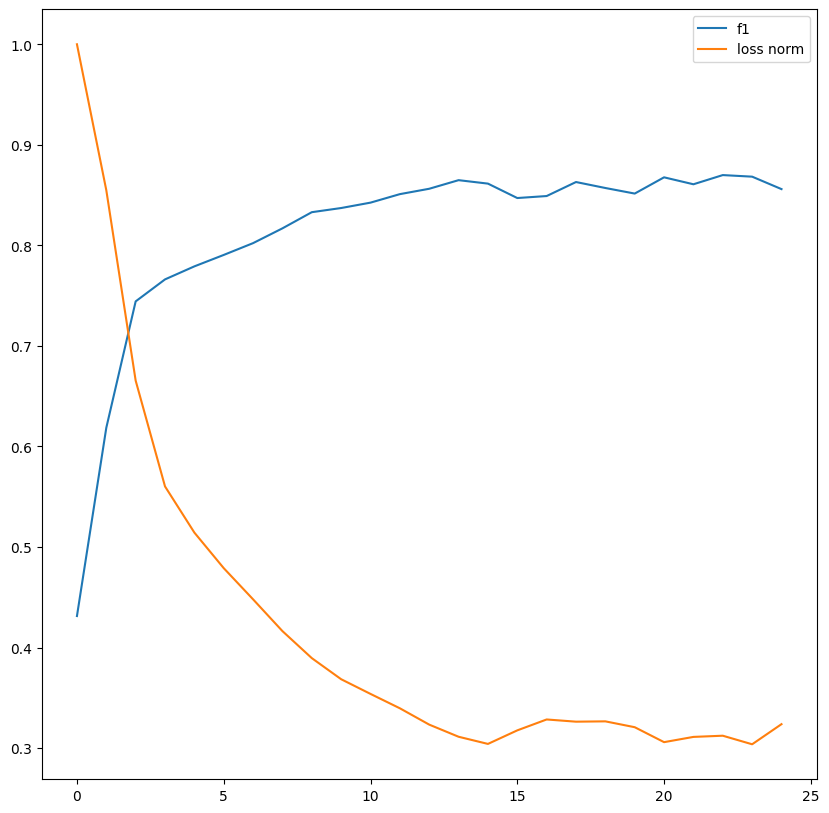

In [14]:
layers = [
    DenseLayer(128, 128, relu, relu_deriv),
    DenseLayer(128, 64, relu, relu_deriv),
    DenseLayer(64, 32, relu, relu_deriv),
    DenseLayer(32, 16, relu, relu_deriv),
    DenseLayer(16, 8, relu, relu_deriv),
    DenseLayer(8, 4, relu, relu_deriv),
    DenseLayer(4, 5, stable_softmax, lambda x: 1)
]

model = MLP(layers, lr=0.0005)
history = model.train(X, Y, epochs=100, stopper = 5, echo_epoch= 10)
plt.plot(history["f1"], label = "f1")
plt.plot(history["loss"]/max(history["loss"]), label = "loss norm")
plt.legend()

In [15]:
import seaborn as sns

def check_confusion_matrix(Y_pred, Y_true, encoder=None, class_names=None, title = "Матриця відповідностей (Confusion Matrix)"):
    y_true = np.argmax(Y_true, axis=1)
    y_pred = np.argmax(Y_pred, axis=1)
    if encoder is not None and class_names is None:
        class_names = encoder.categories_[0]
    n_classes = len(np.unique(y_true))
    conf_mat = np.zeros((n_classes, n_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        conf_mat[t, p] += 1
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names is not None else range(n_classes),
                yticklabels=class_names if class_names is not None else range(n_classes))
    plt.xlabel("Передбачено")
    plt.ylabel("Істинно")
    plt.title(title)
    plt.show()
    accuracy = np.trace(conf_mat) / np.sum(conf_mat)
    print(f"Точність (Accuracy): {accuracy:.4f}")
    return conf_mat

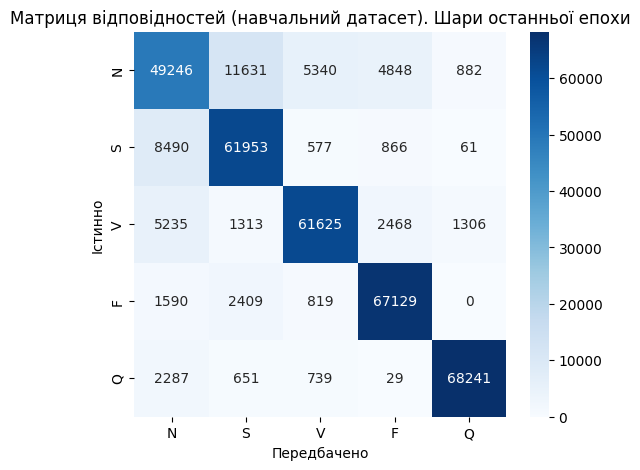

Точність (Accuracy): 0.8567


array([[49246, 11631,  5340,  4848,   882],
       [ 8490, 61953,   577,   866,    61],
       [ 5235,  1313, 61625,  2468,  1306],
       [ 1590,  2409,   819, 67129,     0],
       [ 2287,   651,   739,    29, 68241]])

In [16]:
Y_pred = model.forward(X)
check_confusion_matrix(Y_pred, Y, class_names=["N", "S", "V", "F", "Q"], title = "Матриця відповідностей (навчальний датасет). Шари останньої епохи")

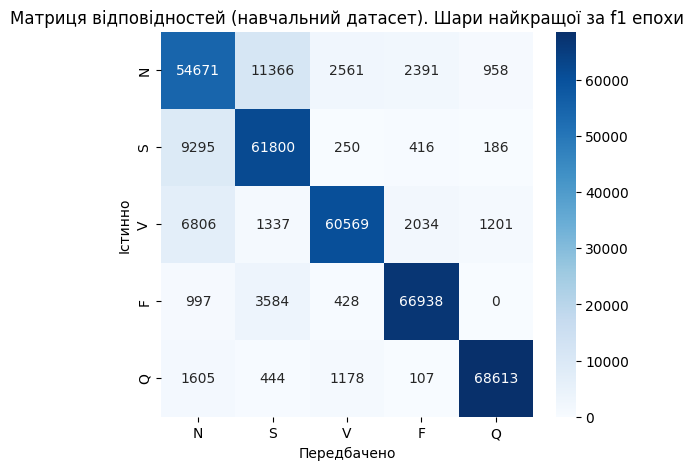

Точність (Accuracy): 0.8689


array([[54671, 11366,  2561,  2391,   958],
       [ 9295, 61800,   250,   416,   186],
       [ 6806,  1337, 60569,  2034,  1201],
       [  997,  3584,   428, 66938,     0],
       [ 1605,   444,  1178,   107, 68613]])

In [17]:
Y_pred = model.forward(X, best_layers= True)
check_confusion_matrix(Y_pred, Y, class_names=["N", "S", "V", "F", "Q"], title = "Матриця відповідностей (навчальний датасет). Шари найкращої за f1 епохи")

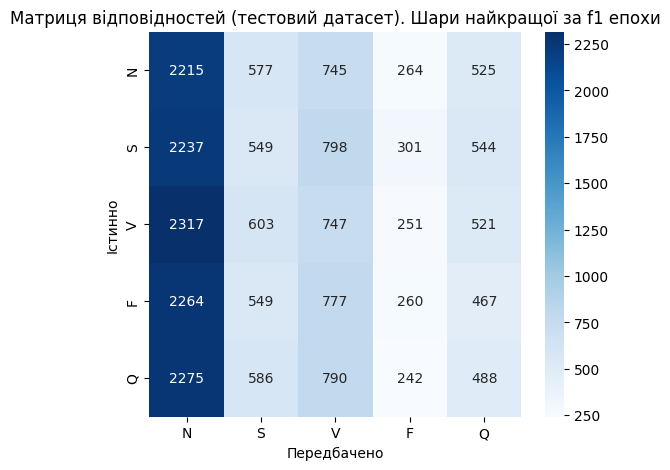

Точність (Accuracy): 0.1945


array([[2215,  577,  745,  264,  525],
       [2237,  549,  798,  301,  544],
       [2317,  603,  747,  251,  521],
       [2264,  549,  777,  260,  467],
       [2275,  586,  790,  242,  488]])

In [18]:
Y_pred_test = model.forward(X_test, best_layers= True)
check_confusion_matrix(Y_pred_test, Y_test, class_names=["N", "S", "V", "F", "Q"], title = "Матриця відповідностей (тестовий датасет). Шари найкращої за f1 епохи")

Модель перенавчається. Застосовано конволюційну модель:

In [37]:
layers = [
    Conv1DLayer(1, 5, 5, relu, relu_deriv),
    Conv1DLayer(5, 5, 5, relu, relu_deriv),
    MaxPool1DLayer(2),
    Conv1DLayer(5, 5, 5, relu, relu_deriv),
    MaxPool1DLayer(2),
    Conv1DLayer(5, 5, 5, relu, relu_deriv),
    MaxPool1DLayer(2),
    Conv1DLayer(5, 5, 5, relu, relu_deriv),
    MaxPool1DLayer(2),
    FlattenLayer(),
    DenseLayer(20, 10, relu, relu_deriv),
    DenseLayer(10, 5, stable_softmax, lambda x: 1)
]
df_balanced = balance_classes(df_train, 187)
X = df_balanced.drop(187, axis=1).to_numpy()
X = (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 1e-9)
y = df_balanced[187].to_numpy().reshape(-1, 1)
enc = OneHotEncoder(sparse_output=False)
Y = enc.fit_transform(y)
model = MLP(layers, lr=0.0025)
history = model.train(X, Y, batch_size = 1024, epochs=10, stopper = 10, echo_epoch = 1, revert_best=False)

Epoch   1 | loss=1715.775 | f1=0.2337
Epoch   2 | loss=1555.261 | f1=0.2735
Epoch   3 | loss=1502.608 | f1=0.3194
Epoch   4 | loss=1467.562 | f1=0.3455
Epoch   5 | loss=1439.711 | f1=0.3790
Epoch   6 | loss=1416.412 | f1=0.4231
Epoch   7 | loss=1396.345 | f1=0.4513
Epoch   8 | loss=1378.503 | f1=0.4674
Epoch   9 | loss=1362.007 | f1=0.4802
Epoch  10 | loss=1346.353 | f1=0.4926


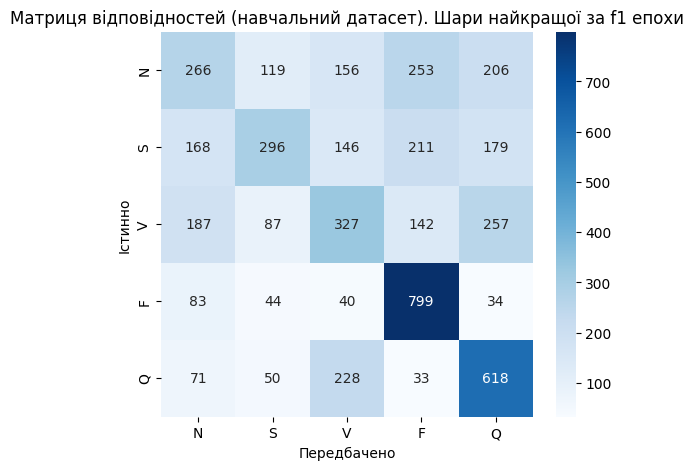

Точність (Accuracy): 0.4612


array([[266, 119, 156, 253, 206],
       [168, 296, 146, 211, 179],
       [187,  87, 327, 142, 257],
       [ 83,  44,  40, 799,  34],
       [ 71,  50, 228,  33, 618]])

In [ ]:
Y_pred = model.forward(X, best_layers= True)
check_confusion_matrix(Y_pred, Y, class_names=["N", "S", "V", "F", "Q"], title = "Матриця відповідностей (навчальний датасет). Шари найкращої за f1 епохи")

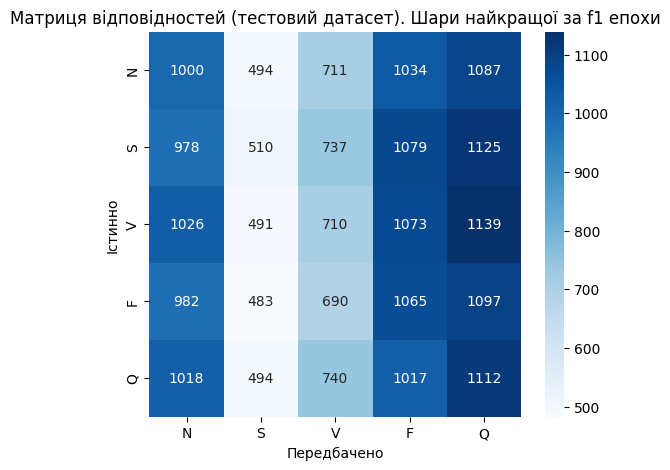

Точність (Accuracy): 0.2008


array([[1000,  494,  711, 1034, 1087],
       [ 978,  510,  737, 1079, 1125],
       [1026,  491,  710, 1073, 1139],
       [ 982,  483,  690, 1065, 1097],
       [1018,  494,  740, 1017, 1112]])

In [ ]:
Y_pred = model.forward(X_test, best_layers= True)
check_confusion_matrix(Y_pred, Y_test, class_names=["N", "S", "V", "F", "Q"], title = "Матриця відповідностей (тестовий датасет). Шари найкращої за f1 епохи")

Не було створено подальших більш адекватних моделей через неймовірно великий час тренування через однопоточне процессорне обчислення власно-реалізованого класу.

Клас побудовано правильно, модель не побудовано